In [1]:
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display # to display images
import torchvision as thv
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torch

## Q2

In [2]:
def shuffle_dataset(X, Y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    return X[indices], Y[indices]

def subsample(dataset, num_samples, num_classes):
    X = dataset.data.numpy()

    # flatten X and change type
    X = X.reshape(X.shape[0], -1).astype(np.float32)

    Y = np.array(dataset.targets)

    # final size of each class
    class_size = int(num_samples / 10)
    indices = []

    for label in range(num_classes):
        # find indices for the given label and select the first class_size elements
        label_indices = np.argwhere(Y == label)[:class_size].flatten()
        indices.extend(label_indices)

    indices = np.array(indices)
    sampled_X = X[indices]
    sampled_Y = Y[indices]

    # normalize x
    sampled_X = sampled_X / 255.0

    return sampled_X, sampled_Y

def batch_generator(X, Y, batch_size):
    while True:
        X, Y = shuffle_dataset(X, Y)
        for i in range((X.shape[0] - batch_size) // batch_size):
            yield X[i * batch_size: i * batch_size + batch_size], Y[i * batch_size: i * batch_size + batch_size]

np.random.seed(20)

# load dataset
train = thv.datasets.MNIST('./', download=True, train=True)
val = thv.datasets.MNIST('./', download=True, train=False)

trainX, trainY = subsample(dataset=train, num_samples=10*1000, num_classes=10)
valX, valY = subsample(dataset=val, num_samples=500*10, num_classes=10)

In [3]:
def resize_images(df, old, new):
    df_temp = df
    num_samples = df_temp.shape[0]
    df_temp = df_temp.reshape((num_samples, old, old))
    downsized = np.zeros((num_samples, new, new))
    for ix in range(num_samples):
        downsized[ix] = cv2.resize(df_temp[ix], (new, new))
        _, downsized[ix] = cv2.threshold(downsized[ix]*255,127,1,cv2.THRESH_BINARY)
    downsized = downsized.reshape((num_samples, new**2))
    return downsized

In [4]:
resized_train_x = resize_images(trainX, 28, 14)
resized_val_x = resize_images(valX, 28, 14)

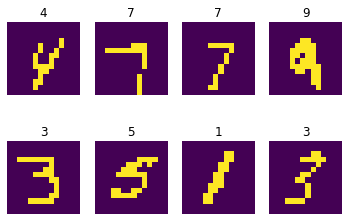

In [5]:
fig, axs = plt.subplots(2, 4)
index = np.random.randint(len(trainX), size=8)
i = 0

for r in range(2):
    for c in range(4):
        axs[r, c].imshow(resized_train_x[index[i]].reshape(14, 14))
#         print(resized_train_x[index[i]])
        axs[r, c].set_title(str(trainY[index[i]]))
        axs[r, c].axis('off')
        i+=1

In [6]:
BATCH_SIZE = 64
train_dataloader = batch_generator(resized_train_x, trainY, batch_size=BATCH_SIZE)
val_dataloader = batch_generator(resized_val_x, valY, batch_size=BATCH_SIZE)

In [7]:
def KL(mu, sigma):
    runningKL = 0
    contribution = 1 + sigma - mu**2 - torch.exp(sigma)
    return (torch.sum(-contribution/2))
    
def AELoss(x, mu, sigma, decoding):
    kl_loss = KL(mu, sigma)
    
    bce =  F.binary_cross_entropy(decoding, x)
    
#     bce = nn.BCELoss()(decoding, x)
    print('kl: ', kl_loss, 'bce: ', bce)
    return (kl_loss + bce, kl_loss, bce)

In [8]:
# def loss(x, mu, sigma, y):
#     # how well do input x and output recon_x agree?
#     BCE = nn.BCELoss()(y, x.reshape((x.shape[0], -1)))

#     # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     KLD = 0
#     for i in range(8):
#         KLD += torch.sum((1 + torch.log(sigma[i]**2) - mu[i]**2 - sigma[i]**2)) / (-2)
    
#     # Normalise by same number of elements as in reconstruction
#     KLD /= mu.shape[0]

#     # BCE tries to make our reconstruction as accurate as possible
#     # KLD tries to push the distributions as close as possible to unit Gaussian  
#     return BCE + KLD

1. Two fully-connected layers
    - first has 196 inputs and 128 outputs + tanh nonlinearity
    - second has 128 inputs and 16 outputs + no nonlinearity
1. Decoder takes as an input z, pushes it through:
    - one layer with 128 outputs + tanh nonlinearity
    - another layer with 196 output neurons + sigmoid nonlinearity

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(196, 128)
        self.fc2 = nn.Linear(128, 8)
        self.fc3 = nn.Linear(128, 8)

    def forward(self, x):
        reshaped = x.reshape(x.shape[0], -1)
        out = torch.tanh(self.fc1(reshaped))
        mu = self.fc2(out)
        logvar = self.fc3(out)
        
        std = logvar.mul(0.5).exp_()
        eps = torch.empty_like(std).normal_()
        z = eps.mul(std).add_(mu)
        
        return z, mu, logvar
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 196)

    def forward(self, x):
        out = torch.tanh(self.fc1(x))
        out = torch.sigmoid(self.fc2(out))
        return out

In [15]:
lr = 1e-3

encoder = Encoder()
decoder = Decoder()

total_params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(total_params, lr = lr)

In [16]:
for name, param in encoder.named_parameters():
    if param.requires_grad:
        print( name)

fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias


In [17]:
for name, param in decoder.named_parameters():
    if param.requires_grad:
        print( name)

fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [18]:
train_error_list, train_loss_list, val_error_list, val_loss_list = [], [], [], []

In [22]:
for t in range(5000):
    # 1. sample a mini-batch of size bb = 32
    x, y = train_dataloader.__next__()

    x = torch.Tensor(x)
    y = torch.Tensor(y).long()
    
#     print(x.shape, "X shape")
#     print(y.shape, "Y shape")

    optimizer.zero_grad()

    z, mu, logvar = encoder(x)
    decoding = decoder(z)
    
#     print(x.shape, decoding.shape)
        
    total_loss, kl, bce = AELoss(x, mu, logvar, decoding)
    total_loss.backward()

    optimizer.step()

#     print(t, kl.item(), bce.item(), total_loss.item())
    print(t, total_loss.item())
    train_loss_list.append(total_loss.item())

kl:  tensor(0.0006, grad_fn=<SumBackward0>) bce:  tensor(0.2524, grad_fn=<BinaryCrossEntropyBackward>)
0 0.2530290186405182
kl:  tensor(0.0006, grad_fn=<SumBackward0>) bce:  tensor(0.2593, grad_fn=<BinaryCrossEntropyBackward>)
1 0.25997182726860046
kl:  tensor(0.0005, grad_fn=<SumBackward0>) bce:  tensor(0.2515, grad_fn=<BinaryCrossEntropyBackward>)
2 0.25199130177497864
kl:  tensor(0.0006, grad_fn=<SumBackward0>) bce:  tensor(0.2457, grad_fn=<BinaryCrossEntropyBackward>)
3 0.24625340104103088
kl:  tensor(0.0006, grad_fn=<SumBackward0>) bce:  tensor(0.2537, grad_fn=<BinaryCrossEntropyBackward>)
4 0.2542930543422699
kl:  tensor(0.0006, grad_fn=<SumBackward0>) bce:  tensor(0.2546, grad_fn=<BinaryCrossEntropyBackward>)
5 0.25518879294395447
kl:  tensor(0.0005, grad_fn=<SumBackward0>) bce:  tensor(0.2563, grad_fn=<BinaryCrossEntropyBackward>)
6 0.25675320625305176
kl:  tensor(0.0004, grad_fn=<SumBackward0>) bce:  tensor(0.2508, grad_fn=<BinaryCrossEntropyBackward>)
7 0.251205176115036
kl: 

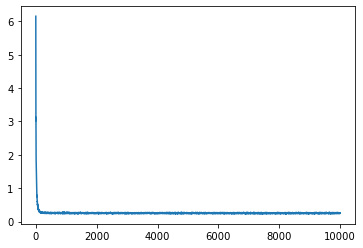

In [23]:
plt.plot(train_loss_list)

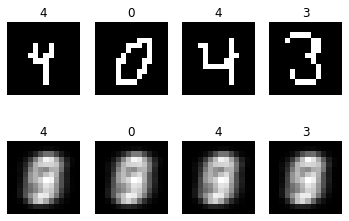

In [24]:
fig, axs = plt.subplots(2, 4)

num_samples = 4
index = np.random.randint(len(resized_val_x), size=8)
i = 0

# for r in range(2):

for c in range(num_samples):
    x = resized_val_x[index[i]]
    axs[0, c].imshow(x.reshape(14, 14), cmap=plt.cm.gray)
    axs[0, c].set_title(str(valY[index[i]]))
    axs[0, c].axis('off')
    
    x = torch.Tensor(x).unsqueeze(0)
    
    
    z, mu, sigma = encoder(x)
    decoding = decoder(z)
    
#     print(decoding)
    decoding = decoding.reshape((14, 14)).detach().numpy()
#     _, decoding = cv2.threshold(decoding*255,127,255,cv2.THRESH_BINARY)

    axs[1, c].imshow(decoding, cmap=plt.cm.gray)
    axs[1, c].set_title(str(valY[index[i]]))
    axs[1, c].axis('off')
    i+=1
plt.show()    

In [ ]:
# for t in range(1000):
#     x, y = train_dataloader.__next__()
#     x = torch.Tensor(x)
#     y = torch.Tensor(y).long()
    
#     enc_optim.zero_grad()
#     dec_optim.zero_grad()
    
#     encoding = enc(x)
#     mu    = encoding[:,  :8]
#     sigma = encoding[:, 8: ]
#     decoding = dec(x)
    
#     kl = loss(x, mu, sigma, decoding)
#     kl.backward()

#     enc_optim.step()
#     dec_optim.step()
    
#     print(t, total_loss.item())
#     train_loss_list.append(total_loss.item())